# Ranking Doctors' Performance on Avoiding Surgery for Benign Polyps

### An illustration of how to programatically sort doctors based on historical performance.

Medical literature suggests that for patients who are diagnosed with benign colorectal polyps, the gastroenterologist performing the colonoscopy should avoid referring patients for colectomy to remove the polyp. Such a referral can lead to adverse side effects, a much higher rate of mortality, and is significantly more costly than endoscopy, the recommended treatment for such diagnoses.

We can summarize this information into a single rule: The *best* doctors avoid referring patients to surgery for benign polyps. In this notebook, we will demonstrate a system that pulls data from an insurance claims database to evaluate doctor performance on this rule.

## Theoretical Foundation

We are interested in estimating a doctor's *violation rate*, which is defined to be the proportion of patients diagnosed with strictly benign colorectal polyps who are incorrectly referred for a colectomy. This rate can be thought of as a random variable following some distribution, which suggests a Bayesian statistical approach to estimating it based on historical data.

Let $p_d$ denote the violation rate for doctor $d$. In 2014, incidence of surgery for benign polyps was found to be 9.4% on average. Knowing nothing else about a specific doctor, then, we may assume a normal prior centered around this average: 
$$p_d \sim \mathcal{N}(0.094, \sigma^2)$$
where $\sigma^2$ is chosen to be some number representing the expected spread in a doctor's violation rate.

Given data for the number of patients diagnosed by a doctor with benign polyps and the number of patients who were then referred for colectomy, we can assume a binomial likelihood. To be precise, let $n_d$ denote the number of patients diagnosed with benign polyps by doctor $d$, and let $k_d$ denote the number of patients the doctor incorrectly referred for colectomy. Then the probability of seeing $k_d$ incorrect referrals out of $n_d$ patients for a doctor with violation rate $p_d$ is written

$$
    P(n_d, k_d | p_d) = \binom{n_d}{k_d} (p_d)^{k_d}(1-p_d)^{n_d - k_d}
$$

Armed with a likelihood function and prior distribution on the unknown $p_d$, we can unleash the power of Bayesian statistics to compute a posterior distribution, $f(p_d | n_d, k_d)$, that incorporates all observations into our prior assumptions. This posterior contains rich information about the unknown violation rate and can be incorporated into further analysis and decision making.

## Implementation

### Data Processing

Before any analysis can be performed, we must first compile data for each doctor's violation rate. To do so, we make use of the `DiagnosisProceduresLoader`, a Python class designed to query a SQL database for information about patients who received specific diagnoses and received / did not receive a consequent procedure.

The `DiagnosisProceduresLoader` requires a collection of ICD-9 diagnosis codes (in our case, 211.3 and 211.4 specify benign colon polyps), a collection of CPT procedure codes (`44110`, `44146`, `44150-44160`; `44204-44208`; `44210-44212` for colectomies), and a string pattern specifying diagnosis codes to exclude (for us, we want to ignore patients who were also diagnosed with malignant polyps, so we filter out CPT codes of the form `152.*`). Provided this information, it returns a Pandas dataframe whose columns are `doctor_id`, `num_diagnosed`, and `num_operated_on`. Going with our theoretical setup specified above, the last two columns, respectively, are $n_d$ and $k_d$.

In the following code block, we initialize a `DiagnosisProceduresLoader` with the specified codes and exclusions, then save the data it passes back and take a peek at some of its rows.

In [1]:
from dataloader import DiagnosisProceduresLoader
import numpy as np

diagnosis_codes = ['211.3', '211.4']
procedure_codes = ['44110', '44146', '44150', '44151', '44152', '44153', '44154', '44155',
	               '44156', '44157', '44158', '44159', '44160', '44204', '44205', '44206',
	               '44207', '44208', '44210', '44211', '44212']
excluded_diagnoses = '152.%'

with DiagnosisProceduresLoader("./claims.db", diagnosis_codes, procedure_codes, excluded_diagnoses) as dataloader:

    doctor_violations_data = dataloader.get_doctor_diagnosis_procedure_data()

doctor_violations_data.head()

,num_diagnosed,num_operated_on
doctor_id,,
e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855,379,21.0
23b0a63eef22daa768ad0dbe859fe9b05dfe76442db350c601a25f7b9b1c2922,66,16.0
d8f80720638b85b0ba9f17e6f2f4370385803b625b1dfc31b7bc0faf8d406eb9,52,9.0
3f00a875772de0f750089e62fc8363a6ec09cbf95e45cd852460787149ce08bc,45,12.0
cdfc8b6e8462fba46825f34af50f5eea1cfe0799f3f2224ddadd20705b971a50,44,8.0


### Statistical Analysis

We now employ the `RateEstimator` Python class to perform Bayesian analysis on each doctor's violation rate. The `RateEstimator` accepts as arguments an assumed `prior` distribution on the rate being modeled, the `support` or domain on which the rate is assumed to be defined, and then our observations of `num_successes` (in our setup, a "success" in the binomial likelihood is actually a failure by the doctor in issuing an incorrect referral, i.e. `num_operated_on` from the dataframe above) and `num_trials` (`num_diagnosed` in our data).

Prior distributions are given in discretized form, with specified density values over a finite grid, as opposed to a closed form representation. This allows for more general flexibility in choice of distribution for the `RateEstimator`. Likewise, `support` is also passed in as a finite grid.

We will need to create a `RateEstimator` for each doctor whose performance we want to model. Because the number of doctors in the database is so large, we will restrict our analysis in this demonstration to the top 5 doctors in terms of diagnosis frequency (`num_diagnosed`).

We assign each doctor the same prior distribution. For the purposes of this notebook, we will assume a spread (or variance) of 0.0009 (which yields a standard deviation of 0.03, meaning we expect a doctor's violation rate to be between 0.064 and 0.124 two thirds of the time, and almost always between 0.004 and 0.184). So for each doctor $d$, we assume that $p_d \sim \mathcal{N}(0.094, 0.0009)$

If results are unsatisfactory or inaccurate based on this assumption, the prior distribution can be further tuned based on domain expertise.

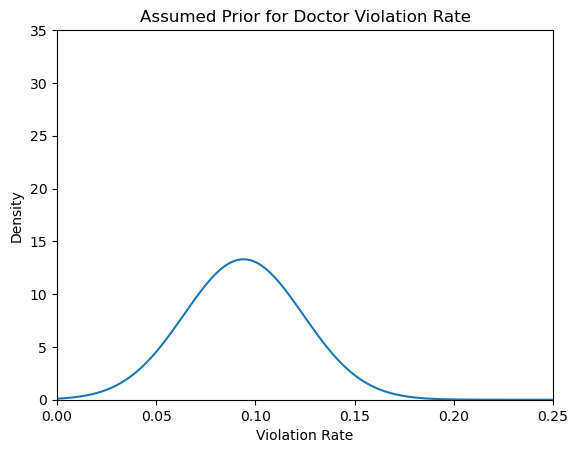

In [2]:
from scipy import stats
import matplotlib.pyplot as plt

mean = 0.094
stdev = 0.03
support = np.linspace(0, 1, 1000)
prior = stats.norm.pdf(support, loc=mean, scale=stdev) 

plt.title("Assumed Prior for Doctor Violation Rate")
plt.xlabel("Violation Rate")
plt.ylabel("Density")
plt.xlim(0, 0.25)
plt.ylim(0, 35)
plt.plot(support, prior)
plt.show()

With our prior created, we now initialize a `RateEstimator` for each doctor in our sample:

In [3]:
from models import RateEstimator

violation_rate_estimators = dict()

cutoff = 5
doctors_to_model = doctor_violations_data.iloc[:cutoff, :]

for doctor_id, (num_diagnosed, num_operated_on) in doctors_to_model.iterrows():

    violation_rate_estimator = RateEstimator(prior, support, num_operated_on, num_diagnosed)
    violation_rate_estimators[doctor_id] = violation_rate_estimator

The first tool provided by the `RateEstimator` class is the ability to plot the posterior distribution of the rate being modeled. Using this method, we can get a visual idea of where each doctor's violation rate lies.

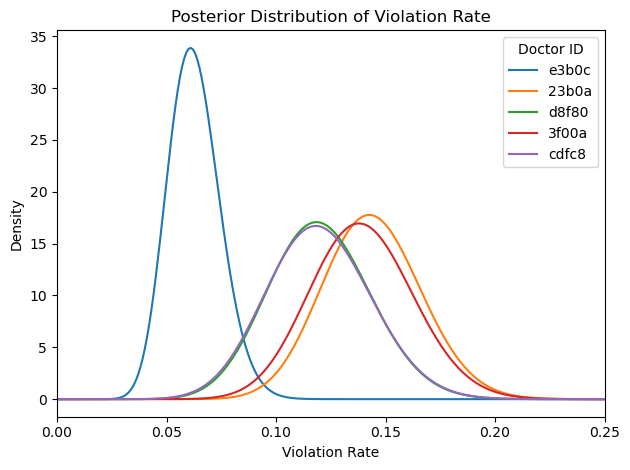

In [4]:
for doctor_id, violation_estimator in violation_rate_estimators.items():
    violation_estimator.plot_posterior(x_lim=(0, 0.25), show=False, label=doctor_id[:5])

plt.title("Posterior Distribution of Violation Rate")
plt.legend(title="Doctor ID")
plt.xlabel("Violation Rate")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

We can also view a few key metrics for each doctor's posterior violation rate. Currently supported metrics are: 

- Expected value (weighted average of the posterior)
- MAP (maximum a posteriori, i.e. the mode of the posterior distribution)
-  $(1 - \alpha)$ Bayesian Credible Interval (an interval centered around the mean of the posterior where $(1 - \alpha)%$ of the probability lies.)

Note that for some forms of posterior distributions, the MAP and Expected Value are essentially identical. But this will not always hold in general.

Let's see each of these metrics for the doctors in our sample:

In [5]:
for doctor_id, violation_estimator in violation_rate_estimators.items():

    truncated_id = doctor_id[:5]
    expected_value = np.round(violation_estimator.compute_expected_value(), 3)
    map_estimate = np.round(violation_estimator.compute_MAP_estimate(), 3)
    credible_interval = np.round(violation_estimator.compute_credible_interval(alpha=0.05), 3)

    print(f"Doctor: {truncated_id}", f"Expected Value: {expected_value}", f"MAP: {map_estimate}", f"0.95 Credible Interval: {credible_interval}", sep="\t|\t")

Doctor: e3b0c	|	Expected Value: 0.063	|	MAP: 0.061	|	0.95 Credible Interval: [0.042 0.086]
Doctor: 23b0a	|	Expected Value: 0.144	|	MAP: 0.142	|	0.95 Credible Interval: [0.102 0.188]
Doctor: d8f80	|	Expected Value: 0.12	|	MAP: 0.118	|	0.95 Credible Interval: [0.077 0.166]
Doctor: 3f00a	|	Expected Value: 0.139	|	MAP: 0.138	|	0.95 Credible Interval: [0.096 0.185]
Doctor: cdfc8	|	Expected Value: 0.12	|	MAP: 0.118	|	0.95 Credible Interval: [0.076 0.167]


### Ranking Doctors

We now come to the crux of our analysis: How do we rank our sample of doctors given the data? That can depend on which metric you'd like to use. Due to this ambiguity, we will utilize a flexible `DoctorRanker` object that, along with the estimator objects to rank, accepts a `RankCriteria` specifying how to rank the doctors.

The `RankCriteria` is essentially a tuple specifying the metric to rank with and the ordering to use for ranking (i.e. ascending or descending, depending on if a lower metric value is better/worse).

For our problem, we will examine how using differing metrics results in different rankings. We first create three criteria objects for these ranking tasks:

In [6]:
from ranking import DoctorRanker, RankCriteria
from util import metrics, orderings

expected_value_criteria = RankCriteria(metrics.EXPECTED_VALUE, orderings.ASCENDING)
map_criteria = RankCriteria(metrics.MAP, orderings.ASCENDING)
credible_interval_criteria = RankCriteria(metrics.CREDIBLE_INTERVAL, orderings.ASCENDING)

Next, we intialize a `DoctorRanker` for each type of ranking criteria:

In [7]:
expected_value_ranker = DoctorRanker(violation_rate_estimators, expected_value_criteria)
map_ranker = DoctorRanker(violation_rate_estimators, map_criteria)
credible_interval_ranker = DoctorRanker(violation_rate_estimators, credible_interval_criteria)

Finally, we examine the rankings produced for each metric by calling the `get_rankings` method of the `DoctorRanker`. Rankings are returned as a dictionary mapping `rank` to an unordered set containing tuples `(doctor_id, metric)`:

In [8]:
print("Rankings of Doctors Based on Expected Posterior Violation Rate:")
expected_value_ranker.get_rankings()

Rankings of Doctors Based on Expected Posterior Violation Rate:


{1: {('e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855',
   0.06273554192858036)},
 2: {('cdfc8b6e8462fba46825f34af50f5eea1cfe0799f3f2224ddadd20705b971a50',
   0.11984297818282247)},
 3: {('d8f80720638b85b0ba9f17e6f2f4370385803b625b1dfc31b7bc0faf8d406eb9',
   0.12015882771943942)},
 4: {('3f00a875772de0f750089e62fc8363a6ec09cbf95e45cd852460787149ce08bc',
   0.13933081518148924)},
 5: {('23b0a63eef22daa768ad0dbe859fe9b05dfe76442db350c601a25f7b9b1c2922',
   0.1439710066279225)}}

In [9]:
print("Rankings of Doctors Based on Violation Rate MAP Estimate:")
map_ranker.get_rankings()

Rankings of Doctors Based on Violation Rate MAP Estimate:


{1: {('e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855',
   0.06106106106106106)},
 2: {('cdfc8b6e8462fba46825f34af50f5eea1cfe0799f3f2224ddadd20705b971a50',
   0.11811811811811812)},
 3: {('d8f80720638b85b0ba9f17e6f2f4370385803b625b1dfc31b7bc0faf8d406eb9',
   0.11811811811811812)},
 4: {('3f00a875772de0f750089e62fc8363a6ec09cbf95e45cd852460787149ce08bc',
   0.13813813813813813)},
 5: {('23b0a63eef22daa768ad0dbe859fe9b05dfe76442db350c601a25f7b9b1c2922',
   0.14214214214214213)}}

Note that the rankings produced by the `credible_interval_ranker` allow for "ties" between doctors. The intuition here is that if credible intervals overlap, doctor performance is largely indistinguishable given the available data. Thus, a ranking system should not necessarily rank doctors based on just the left endpoint of their credible interval for violation rate. A more nuanced approach is taken in the `DoctorRanker` class (for details, examine the docstrings in the class definition).

In [10]:
print("Rankings of Doctors Based on 0.95 Bayesian Credible Intervals for Violation Rate:")
credible_interval_ranker.get_rankings()

Rankings of Doctors Based on 0.95 Bayesian Credible Intervals for Violation Rate:


{1: {('cdfc8b6e8462fba46825f34af50f5eea1cfe0799f3f2224ddadd20705b971a50',
   (0.07607607607607608, 0.16716716716716717)),
  ('d8f80720638b85b0ba9f17e6f2f4370385803b625b1dfc31b7bc0faf8d406eb9',
   (0.07707707707707707, 0.16616616616616617)),
  ('e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855',
   (0.04204204204204204, 0.08608608608608609))},
 2: {('23b0a63eef22daa768ad0dbe859fe9b05dfe76442db350c601a25f7b9b1c2922',
   (0.1021021021021021, 0.1881881881881882)),
  ('3f00a875772de0f750089e62fc8363a6ec09cbf95e45cd852460787149ce08bc',
   (0.0960960960960961, 0.18518518518518517))}}

## Conclusion

Thus, in the sample of doctors we have analyzed, we can generate a ranking for each doctor based on historical performance. In the context of the larger problem, this allows us to learn from the data which doctors are best at avoiding unnecessary and costly referrals for colectomy. For decision makers, this information is absolutely crucial in recommending which doctor a patient should visit.

The system introduced in this demonstration can easily be extended to other, similar rules -- Simply change the diagnosis codes and procedure codes supplied to the `DiagnosisProceduresLoader` and supply a new `RankCriteria` to the `DoctorRanker`. Further metrics can also be added to the capabilities of the `RateEstimator` for additional future analysis.